# Setting up the environment
## Install requirements

In [4]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz -o /content/drive/MyDrive/wdir/growth-hacking-sentiment/data/Video_Games_5.json.gz
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !wget https://raw.githubusercontent.com/crow-intelligence/growth-hacking-sentiment/master/requirements.txt
!pip install -r /content/drive/MyDrive/wdir/growth-hacking-sentiment/requirements.txt

## Install apex

In [1]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex


Writing setup.sh


In [ ]:
!sh setup.sh

## Connect your Colab notebook to your Drive

In [5]:
!ls /content/drive/MyDrive/Colab/data/corpus.csv

ls: cannot access '/content/drive/MyDrive/Colab/data/corpus.csv': No such file or directory


In [267]:
import json
import gzip
import pandas as pd

path_data="/content/drive/MyDrive/wdir/growth-hacking-sentiment/data/"
path_plots="/content/drive/MyDrive/wdir/growth-hacking-sentiment/plots"
filename = 'Video_Games_5.json'  # Sample file.

df = pd.read_json(path+filename, lines=True)
df.sample(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
91862,4,True,"10 10, 2014",A2L5GXFHNXTHQ3,B000HNJ5WE,Herbus61,"Excellent game fulfilled my expectations, I ho...",Four Stars,1412899200,NaN,{'Format:': ' Video Game'},NaN
413807,5,True,"01 23, 2016",A30VWR3OM0S5DV,B011ERY5IA,richard,absolutely great story rich game. the vita is ...,Five Stars,1453507200,NaN,NaN,NaN
304253,5,True,"09 8, 2014",AZIIM0UOCTSHV,B00CPKUV9I,Matthew C. Last,"Well, as you may have guessed this is a game w...",Nazi Murder is the best sort of murder!,1410134400,3,{'Platform:': ' PC'},NaN


In [268]:
#@markdown Expand style columns 
def expand_style(sty):
    s = {'Color:', 'Edition:', 'Format:', 'Platform:', 'Size:', 'Style:'}
    def f(sty, key):
        try: return sty[key]
        except: None
    try: return {key.strip(":"):f(sty, key) for key in s}
    except: return {}

df=df.drop(columns=["style"])\
    .join(pd.DataFrame(list(df["style"]
                            .apply(expand_style))
    )
)

In [270]:
df["date"] = pd.to_datetime(df['unixReviewTime'], unit='s')
df.drop(columns=["unixReviewTime", "reviewTime"], inplace=True)
df["vote"]=df["vote"].str.replace(",",'').astype(float)
df["Platform"]=pd.Categorical(df.Platform)
df["Format"]=pd.Categorical(df.Format)

In [328]:
df.to_parquet("/content/drive/MyDrive/wdir/growth-hacking-sentiment/data/Video_Games_5.parquet")

# Create corpus

In [331]:
#@title Corpus
import ndjson
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

###############################################################################
#####                                Corpus                               #####
###############################################################################
#### keys
## all
#'overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName',
# 'reviewText', 'summary', 'unixReviewTime'
## optional
# vote
ratings = []
reviews = []
summaries = []
with open(path+"/Video_Games_5.json", "r") as infile:
    reader = ndjson.reader(infile)

    for review in reader:
        try:
            rating = review["overall"]
            rv = review["reviewText"]
            s = review["summary"]
        except Exception as e:
            continue
        if len(rv) > 0 and len(s) > 0:
            ratings.append(rating)
            reviews.append(rv)
            summaries.append(s)

In [349]:
#@title The distribution of stars
from collections import Counter
import altair as alt
import pandas as pd

# let's see the distributions

# the distribution of review ratings
rating_counts = Counter(ratings)
data1 = pd.DataFrame(
    {
        "ratings": [str(e) for e in list(rating_counts.keys())],
        "counts": list(rating_counts.values()),
    }
)

chart1 = alt.Chart(data1).mark_bar().encode(x="ratings", y="counts")
chart1.save(path_plots+"/rating_counts.html")
chart1


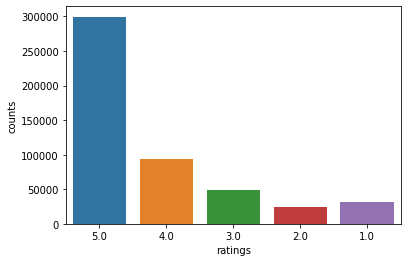

In [348]:
import seaborn as sns
plot = sns.barplot(x=data1["ratings"],
             y=data1["counts"]
             )
fig = plot.get_figure()
fig.savefig(path_plots+"/rating_counts.png") 

In [332]:
#@title Sample
indices = list(range(len(reviews)))

# using the same seed (random_stat=42) you can get the same samples!
rus = RandomUnderSampler(
    sampling_strategy={1.0: 1000, 2.0: 1000, 3.0: 1000, 4.0: 1000, 5.0: 1000},
    random_state=42,
)
indices_sample, ratings_sample = rus.fit_resample(
    np.array(indices).reshape(-1, 1), np.array(ratings).reshape(-1, 1)
)

indices_sample = np.ndarray.flatten(indices_sample)
indices_other = [i for i in list(range(len(reviews))) if i not in indices_sample]
reviews_sample = [reviews[i] + " " + summaries[i] for i in indices_sample]
reviews_other = [reviews[i] for i in indices_other]

np.random.seed(42)
big_sample = np.random.randint(len(reviews_other), size=10000)
reviews_to_be_saved = [reviews_other[i].replace("\n", " ") for i in big_sample]
reviews_to_be_saved = "\n".join(reviews_to_be_saved)

df = pd.DataFrame({"rating": ratings_sample, "review": reviews_sample})

with open(path+"/raw/review_corpus.tsv", "w") as outfile:
    outfile.write(df.to_csv(index=False, sep="\t"))

with open(path+"/raw/reviews_without_ratings.txt", "w") as outfile:
    outfile.write(reviews_to_be_saved)